Detección de caras con webcam

In [1]:
import cv2
import time
import FaceNormalizationUtils as faceutils
# My face detectors interface
import FaceDetectors

En el bucle de procesamiento, las teclas 'd' y 'e' `permiten respectivamente cambiar de modelo de detección de caras, y en su caso de máscara de detección del rostro.

La ejecución de la siguiente celda produce error al no disponer de los archivos shape_predictor_5_face_landmarks.dat y shape_predictor_68_face_landmarks.dat que por su tamaño no se incluyeron en el repositorio. Pueden descargarse desde el enlace proporcionado en el campus virtual (opción aconsejada), o
desde el [repositorio de archivos de dlib](http://dlib.net/files/).



In [2]:
normalizatorHS = faceutils.Normalization()

# Face detectors interface
FDet = FaceDetectors.FaceDetector()

# Fonts
font = cv2.FONT_HERSHEY_SIMPLEX

# Webcam connection
cap = cv2.VideoCapture(0)
# Check for other cameras
if not cap.isOpened():
    cap = cv2.VideoCapture(1)
    if not cap.isOpened():
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print('Camera error')
            exit(0)
        else:
            print('Camera 0')
    else:
        print('Camera 1')
else:
    print('Camera 0')

    # Face detection and eye model setup
imodoF = 0
imodoE = 0

debug = 0

#Set camera resolution
cap.set(3,640);
cap.set(4,480);

while True:
    # Get frame
    t = time.time()
    ret, frame = cap.read()

    if ret:
        # For HS normalization
        B, G, R = cv2.split(frame)

        # Search face with a specific setup for face and eye detection
        values = FDet.SingleFaceEyesDetection(frame, FDet.FaceDetectors[imodoF], FDet.EyeDetectors[imodoE])
        if values is not None:
            face, eyes, shape = values

            #draws face container
            [x, y , w, h] = face
            if x > -1:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

                # draws eyes and mask if available
                [lex, ley, rex, rey] = eyes
                if lex > -1:
                    # Show detected facial elements
                    if imodoF > 0:
                        for (x, y) in shape:
                            cv2.circle(frame, (x, y), 2, (255, 255, 255), -1)

                    cv2.circle(frame, ((int)(lex), (int)(ley)), 4, (0, 0, 255), -1)
                    cv2.circle(frame, ((int)(rex), (int)(rey)), 4, (0, 255, 0), -1)


                    # Normalize and show
                    # color channels
                    normalizatorHS.normalize_gray_img(B, lex, ley, rex, rey, faceutils.Kind_wraping.HS)
                    Bnorm = normalizatorHS.normf_image
                    normalizatorHS.normalize_gray_img(G, lex, ley, rex, rey, faceutils.Kind_wraping.HS)
                    Gnorm = normalizatorHS.normf_image
                    normalizatorHS.normalize_gray_img(R, lex, ley, rex, rey, faceutils.Kind_wraping.HS)
                    Rnorm = normalizatorHS.normf_image
                    NormBGR = cv2.merge((Bnorm, Gnorm, Rnorm))
                    cv2.imshow("Normalized", NormBGR)


        if debug:
            print("Processing time : {:.3f}".format(time.time() - t))

        # Show resulting image
        cv2.putText(frame, FDet.FaceDetectors[imodoF], (10, 20), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        if imodoF == 1 or imodoF == 2:
            cv2.putText(frame, FDet.EyeDetectors[imodoE], (50, 20), font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Cam', frame)
        
        # Esc to finish
        tec = cv2.waitKey(40)
        if tec & tec == 27:  # Esc
            break
        # Face detector change
        elif tec & 0xFF == ord('d'):
            imodoF = imodoF + 1
            if imodoF >= len(FDet.FaceDetectors):
                imodoF = 0
        #Eye detector change
        elif tec & 0xFF == ord('e'):
            imodoE = imodoE + 1
            if imodoE >= len(FDet.EyeDetectors):
                imodoE = 0

# Close windoews and release camera
cap.release()
cv2.destroyAllWindows()

Camera 0


## Añadir animación de Rayos

In [3]:
import math 
import random
import cv2
import cv2
# My face detectors interface
import FaceDetectors
FDet = FaceDetectors.FaceDetector()
class Coord:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Coord(self.x - other.x, self.y - other.y)

    def __add__(self, other):
        return Coord(self.x + other.x, self.y + other.y)

    def __mul__(self, factor):
        return Coord(self.x * factor, self.y * factor)

    def __rmul__(self, factor):
        return self.__mul__(factor)

    def __truediv__(self, factor):
        return Coord(self.x / factor, self.y / factor)

    def length(self):
        return math.hypot(self.x, self.y)

    def angle(self):
        return math.atan2(self.y, self.x)

    def normalize(self):
        length = self.length()
        if length == 0:
            return Coord(0, 0)
        return self / length

def rotate_counter_clockwise(coord, rad_angle):
    cos_theta = math.cos(rad_angle)
    sin_theta = math.sin(rad_angle)
    return Coord(
        coord.x * cos_theta - coord.y * sin_theta,
        coord.x * sin_theta + coord.y * cos_theta
    )

def to_quadruple(segment):
    start, end = segment
    return start.x, start.y, end.x, end.y

# Parámetros de los rayos
MAX_OFFSET = 30  # Aumentado para más desplazamiento
LIGHTNING_COLOR = (250, 251, 165)
BOLT_WIDTH = 2
FLASH_PROBABILITY = 0.9  # Mayor probabilidad para asegurar que el rayo aparezca

def generate_single_bolt(origin, tail):
    segments = [(origin, tail)]
    offset = MAX_OFFSET
    length = (tail - origin).length()
    refinement_limit = int(length / 50)  # Aumenta las refinaciones para más detalle
    branch_probability = 0.2  # Probabilidad ajustada para ramificaciones
    branch_segments = []

    for _ in range(refinement_limit):
        new_segments = []
        for segment in segments:
            start, end = segment
            mid = (start + end) / 2
            direction = (end - start).normalize()
            perpendicular = rotate_counter_clockwise(direction, math.pi / 2)

            # Desplazamiento aleatorio perpendicular al segmento
            displacement = random.uniform(-offset, offset)
            mid += perpendicular * displacement

            new_segments.append((start, mid))
            new_segments.append((mid, end))

            # Lógica de ramificación
            if random.random() < branch_probability:
                branch_dir = rotate_counter_clockwise(direction, random.uniform(-math.pi / 2, math.pi / 2))
                branch_length = length * random.uniform(0.1, 0.3)
                branch_end = mid + branch_dir * branch_length
                branch_segments.append((mid, branch_end))

        segments = new_segments
        offset /= 1.5  # Disminuye el desplazamiento para detalles más finos

    # Combina segmentos principales con ramificaciones
    all_segments = segments + branch_segments
    return all_segments

def draw_lightnings(frame, origin, tail):
    if random.random() < FLASH_PROBABILITY:
        bolt_segments = generate_single_bolt(origin, tail)
        for segment in bolt_segments:
            start_pt = (int(segment[0].x), int(segment[0].y))
            end_pt = (int(segment[1].x), int(segment[1].y))
            # Asegura que los puntos están dentro de los límites del frame
            height, width = frame.shape[:2]
            if 0 <= start_pt[0] < width and 0 <= start_pt[1] < height and 0 <= end_pt[0] < width and 0 <= end_pt[1] < height:
                cv2.line(frame, start_pt, end_pt, LIGHTNING_COLOR, BOLT_WIDTH)

# Configuración de la cámara y detección de caras y ojos
cap = cv2.VideoCapture(0)
imodoF = 0
imodoE = 0

debug = 0
cap.set(3, 640)
cap.set(4, 480)

while True:
    # Captura el fotograma de la cámara
    ret, frame = cap.read()
    if not ret:
        break

    # Simulación de detección de ojos (reemplaza con tu código de detección)
    values = FDet.SingleFaceEyesDetection(frame, FDet.FaceDetectors[imodoF], FDet.EyeDetectors[imodoE])
    if values is not None:
        face, eyes, shape = values
        [lex, ley, rex, rey] = eyes

        if lex > -1 and rex > -1:
            # Crear el efecto de rayos en ambos ojos
            left_eye_origin = Coord(lex, ley)
            right_eye_origin = Coord(rex, rey)
            # Puntos de cola ajustados para un mejor efecto visual
            left_eye_tail = Coord(lex + random.randint(-50, 50), ley + random.randint(150, 250))
            right_eye_tail = Coord(rex + random.randint(-50, 50), rey + random.randint(150, 250))

            # Dibujar los rayos desde ambos ojos
            draw_lightnings(frame, left_eye_origin, left_eye_tail)
            draw_lightnings(frame, right_eye_origin, right_eye_tail)

    # Mostrar el video con los rayos
    cv2.imshow('Cam', frame)

    # Presiona 'Esc' para salir
    if cv2.waitKey(1) & 0xFF == 27:  # Tecla 'Esc'
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()


## Máscara de puntos facial con MediaPipe

In [4]:
import cv2
import mediapipe as mp
import numpy as np

# Inicializamos MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def process_frame(frame, face_mesh):
    # Convertir el frame a RGB para procesar con MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    # Crear una imagen en negro del mismo tamaño que el frame
    mesh_image = np.zeros_like(frame)

    # Dibujar la malla facial en la imagen mesh_image
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=mesh_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
            )

    return mesh_image

def main():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

    if not cap.isOpened():
        print("No se puede abrir la cámara")
        exit()

    with mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)

            # Procesar el frame y obtener la imagen de la malla facial
            mesh_image = process_frame(frame, face_mesh)

            cv2.imshow('Original', frame)
            # Mostrar la malla facial en una ventana
            cv2.imshow('Face Mesh', mesh_image)

            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


## Filtro de pikachu

Se lleva a cabo un escaneo inicial de la cara para detectar metricas como que tan compacta está la boca y el largo y ancho de la cara. Esto con el fin de posteriormente detectar si se inflan los mofletes o no. El escaneo se hace de nuevo cada 10 segundos debido a que cambios en la distancia o ángulo de la cara, harían que las métricas sacadas anteriormente queden obsoletas. 

Además, con la librería pygame se añaden un sonido cuando se detecta que los labios se separan y supera el umbral de distancia establecido.

**IMPORTANTE:** Las métricas que deciden si los mofletes están inflados o no las saqué teniendo en cuenta cómo mi cara se deforma. Con la malla de puntos que hice en la tarea anterior comprobé cómo afecta a la malla de puntos esta acción, y noté que la parte inferior de la cara se compactaba, a la vez que el alto de la cara se reducía y el ancho de la cara aumentaba. Puede que no funcionen las métricas que puse para todas las caras, aunque debería funcionar para la mayoría.

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pygame
import threading
import random
import math
import time

class Coord:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # ... [Métodos de la clase Coord sin cambios]

    def __sub__(self, other):
        return Coord(self.x - other.x, self.y - other.y)

    def __add__(self, other):
        return Coord(self.x + other.x, self.y + other.y)

    def __mul__(self, factor):
        return Coord(self.x * factor, self.y * factor)

    def __rmul__(self, factor):
        return self.__mul__(factor)

    def __truediv__(self, factor):
        return Coord(self.x / factor, self.y / factor)

    def length(self):
        return math.hypot(self.x, self.y)

    def angle(self):
        return math.atan2(self.y, self.x)

    def normalize(self):
        length = self.length()
        if length == 0:
            return Coord(0, 0)
        return self / length

def rotate_counter_clockwise(coord, rad_angle):
    cos_theta = math.cos(rad_angle)
    sin_theta = math.sin(rad_angle)
    return Coord(
        coord.x * cos_theta - coord.y * sin_theta,
        coord.x * sin_theta + coord.y * cos_theta
    )

def generate_single_bolt(origin, tail):
    segments = [(origin, tail)]
    offset = MAX_OFFSET
    length = (tail - origin).length()
    refinement_limit = int(length / 50)
    branch_probability = 0.2
    branch_segments = []

    for _ in range(refinement_limit):
        new_segments = []
        for segment in segments:
            start, end = segment
            mid = (start + end) / 2
            direction = (end - start).normalize()
            perpendicular = rotate_counter_clockwise(direction, math.pi / 2)

            displacement = random.uniform(-offset, offset)
            mid += perpendicular * displacement

            new_segments.append((start, mid))
            new_segments.append((mid, end))

            if random.random() < branch_probability:
                branch_dir = rotate_counter_clockwise(direction, random.uniform(-math.pi / 2, math.pi / 2))
                branch_length = length * random.uniform(0.1, 0.3)
                branch_end = mid + branch_dir * branch_length
                branch_segments.append((mid, branch_end))

        segments = new_segments
        offset /= 1.5

    all_segments = segments + branch_segments
    return all_segments

def draw_lightnings(frame, origin, tail):
    if random.random() < FLASH_PROBABILITY:
        bolt_segments = generate_single_bolt(origin, tail)
        for segment in bolt_segments:
            start_pt = (int(segment[0].x), int(segment[0].y))
            end_pt = (int(segment[1].x), int(segment[1].y))
            height, width = frame.shape[:2]
            if 0 <= start_pt[0] < width and 0 <= start_pt[1] < height and 0 <= end_pt[0] < width and 0 <= end_pt[1] < height:
                cv2.line(frame, start_pt, end_pt, LIGHTNING_COLOR, BOLT_WIDTH)

# Parámetros de los rayos
LIGHTNING_COLOR = (250, 251, 165)
BOLT_WIDTH = 4
FLASH_PROBABILITY = 0.9
MAX_OFFSET = 50
TAIL_LENGTH = 200



# Inicializamos MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Inicializar Pygame mixer
pygame.mixer.init()

pika_sound = pygame.mixer.Sound('sounds/pika_sound.mp3')
is_playing_sound = False

def play_sound():
    global is_playing_sound
    if not is_playing_sound:
        is_playing_sound = True
        threading.Thread(target=lambda: pika_sound.play()).start()

        def reset_flag():
            global is_playing_sound
            pygame.time.delay(int(pika_sound.get_length() * 1000))
            is_playing_sound = False

        threading.Thread(target=reset_flag).start()


def overlay_image_alpha(img, img_overlay, x, y):
    """Superpone img_overlay sobre img en la posición (x, y) utilizando el canal alfa."""
    # Rango de imágenes
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]

    # Si no hay canal alfa, se crea uno
    if img_overlay_crop.shape[2] < 4:
        img_overlay_crop = np.concatenate(
            [img_overlay_crop,
             np.ones((img_overlay_crop.shape[0], img_overlay_crop.shape[1], 1), dtype=img_overlay_crop.dtype) * 255],
            axis=2,
        )

    alpha_overlay = img_overlay_crop[:, :, 3] / 255.0
    alpha_background = 1.0 - alpha_overlay

    for c in range(0, 3):
        img_crop[:, :, c] = (
            alpha_overlay * img_overlay_crop[:, :, c] +
            alpha_background * img_crop[:, :, c]
        )

def rotate_image(image, angle):
    """Rota una imagen con el ángulo dado manteniendo el tamaño."""
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))
    return rotated

# Cargar las imágenes de las orejas con canal alfa
left_ear_img = cv2.imread('images/pika_left_ear.png', cv2.IMREAD_UNCHANGED)
right_ear_img = cv2.imread('images/pika_right_ear.png', cv2.IMREAD_UNCHANGED)
SCALE_FACTOR = 2.5 

# Variables globales para almacenar las mediciones iniciales y estado
initial_measurements = {
    'face_height': None,
    'face_width': None,
    'mouth_distance': None
}

measurement_frames = 60  # Número de frames para medir
frame_counter = 0
mofletes_inflados = False
last_measurement_time = time.time()
measurement_interval = 10  # Recalcular cada 10 segundos
recalculating = True  # Estado inicial de recalculación

def process_frame(frame, face_mesh):
    global frame_counter, initial_measurements, mofletes_inflados, last_measurement_time, recalculating
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)
    points_data = {}

    # Crear una copia del frame para dibujar la malla facial
    mesh_image = np.zeros_like(frame)

    current_time = time.time()
    time_since_last_measurement = current_time - last_measurement_time
    time_until_next_measurement = measurement_interval - time_since_last_measurement

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Mostrar la malla facial durante la recalibración
            if recalculating:
                mp_drawing.draw_landmarks(
                    image=frame,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
                )

            # Puntos clave
            points = [10, 152, 93, 323, 13, 14, 67, 103, 297, 332, 54, 284, 205, 425, 4, 98, 327, 33, 263, 1]
            for point in points:
                if point < len(face_landmarks.landmark):
                    x = face_landmarks.landmark[point].x
                    y = face_landmarks.landmark[point].y

                    x_pixel = int(x * frame.shape[1])
                    y_pixel = int(y * frame.shape[0])

                    points_data[point] = {'x': x_pixel, 'y': y_pixel}

            required_points = [10, 152, 93, 323, 13, 14]

            if all(point in points_data for point in required_points):
                # Calcular medidas
                y_top = points_data[10]['y']
                y_bottom = points_data[152]['y']
                face_height = abs(y_bottom - y_top)

                x_left = points_data[93]['x']
                x_right = points_data[323]['x']
                face_width = abs(x_right - x_left)

                mouth_top = points_data[13]
                mouth_bottom = points_data[14]
                mouth_distance = np.linalg.norm(
                    np.array([mouth_top['x'], mouth_top['y']]) -
                    np.array([mouth_bottom['x'], mouth_bottom['y']])
                )

                # Recalibración de medidas
                if recalculating:
                    frame_counter += 1
                    if initial_measurements['face_height'] is None:
                        initial_measurements['face_height'] = face_height
                        initial_measurements['face_width'] = face_width
                        initial_measurements['mouth_distance'] = mouth_distance
                    else:
                        # Promediar las mediciones iniciales
                        initial_measurements['face_height'] = (initial_measurements['face_height'] * (frame_counter - 1) + face_height) / frame_counter
                        initial_measurements['face_width'] = (initial_measurements['face_width'] * (frame_counter - 1) + face_width) / frame_counter
                        initial_measurements['mouth_distance'] = (initial_measurements['mouth_distance'] * (frame_counter - 1) + mouth_distance) / frame_counter

                    # Mostrar texto de escaneo
                    cv2.putText(frame, f"Escaneando rostro... {measurement_frames - frame_counter}", (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                    if frame_counter >= measurement_frames:
                        recalculating = False
                        frame_counter = 0
                        last_measurement_time = time.time()
                else:
                    # Comparar mediciones actuales con las iniciales
                    height_ratio = face_height / initial_measurements['face_height']
                    width_ratio = face_width / initial_measurements['face_width']
                    mouth_ratio = mouth_distance / initial_measurements['mouth_distance']

                    # Umbrales para detectar mofletes inflados
                    height_threshold = 0.98
                    width_threshold = 1.01
                    mouth_threshold = 0.98

                    if width_ratio >= width_threshold and mouth_ratio <= mouth_threshold and height_ratio <= height_threshold:
                        mofletes_inflados = True
                    else:
                        mofletes_inflados = False

                    # Mostrar contador regresivo para próxima recalibración
                    if time_until_next_measurement <= 0:
                        recalculating = True
                        initial_measurements = {'face_height': None, 'face_width': None, 'mouth_distance': None}
                        frame_counter = 0
                        last_measurement_time = current_time
                    else:
                        cv2.putText(frame, f"Recalibracion en: {int(time_until_next_measurement)}s", (50, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Comprobar si la boca está abierta para reproducir el sonido
            if 13 in points_data and 14 in points_data:
                mouth_top = points_data[13]
                mouth_bottom = points_data[14]
                mouth_distance = np.linalg.norm(
                    np.array([mouth_top['x'], mouth_top['y']]) -
                    np.array([mouth_bottom['x'], mouth_bottom['y']])
                )

                if mouth_distance > 15:
                    play_sound()

            # Nariz
            if 4 in points_data and 98 in points_data and 327 in points_data:
                pt1 = (points_data[4]['x'], points_data[4]['y'])
                pt2 = (points_data[327]['x'], points_data[327]['y'])
                pt3 = (points_data[98]['x'], points_data[98]['y'])

                triangle_cnt = np.array([pt1, pt2, pt3])
                cv2.fillPoly(frame, [triangle_cnt], (0, 0, 0))

                line_thickness = 10
                color = (0, 0, 0)

                cv2.line(frame, pt1, pt2, color, thickness=line_thickness, lineType=cv2.LINE_8)
                cv2.line(frame, pt2, pt3, color, thickness=line_thickness, lineType=cv2.LINE_8)
                cv2.line(frame, pt3, pt1, color, thickness=line_thickness, lineType=cv2.LINE_8)

                radius = line_thickness // 2
                cv2.circle(frame, pt1, radius, color, thickness=-1, lineType=cv2.LINE_8)
                cv2.circle(frame, pt2, radius, color, thickness=-1, lineType=cv2.LINE_8)
                cv2.circle(frame, pt3, radius, color, thickness=-1, lineType=cv2.LINE_8)

            # Calcular ángulo de la cara
            if all(k in points_data for k in [33, 263]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))
            else:
                face_angle = 0  # Valor por defecto si no se puede calcular

            # Orejas
            # Calcular ángulo de la cara usando los puntos de los ojos exteriores
            if all(k in points_data for k in [33, 263]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))

            # Orejas: Calcula la posición y rotación
            if all(k in points_data for k in [33, 263, 1, 10, 152]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                face_width = np.linalg.norm(right_eye_outer - left_eye_outer)
                face_height = abs(points_data[152]['y'] - points_data[10]['y'])

                # Tamaño y desplazamiento de las orejas
                ear_size = int(face_width * 0.8)
                ear_size = max(50, min(ear_size, 200))  # Límite del tamaño

                # Redimensionar y rotar imágenes de las orejas
                left_ear_resized = cv2.resize(left_ear_img, (ear_size, ear_size), interpolation=cv2.INTER_AREA)
                right_ear_resized = cv2.resize(right_ear_img, (ear_size, ear_size), interpolation=cv2.INTER_AREA)
                left_ear_rotated = rotate_image(left_ear_resized, face_angle)
                right_ear_rotated = rotate_image(right_ear_resized, face_angle)

                # Calcula posiciones ajustadas para las orejas basadas en la inclinación de la cabeza
                ear_offset_y = face_height * 0.5  # desplazamiento de las orejas sobre los ojos
                left_ear_pos = left_eye_outer + np.array([0, -ear_offset_y])
                right_ear_pos = right_eye_outer + np.array([0, -ear_offset_y])

                # Superponer las orejas en el frame
                overlay_image_alpha(frame, left_ear_rotated, int(left_ear_pos[0] - ear_size / 2), int(left_ear_pos[1] - ear_size / 2))
                overlay_image_alpha(frame, right_ear_rotated, int(right_ear_pos[0] - ear_size / 2), int(right_ear_pos[1] - ear_size / 2))


            # Mofletes
            if 205 in points_data and 425 in points_data and 33 in points_data and 263 in points_data:
                x1_cheek, y1_cheek = points_data[205]['x'], points_data[205]['y']
                x2_cheek, y2_cheek = points_data[425]['x'], points_data[425]['y']

                cheek_distance = np.sqrt((x2_cheek - x1_cheek) ** 2 + (y2_cheek - y1_cheek) ** 2)
                ellipse_axes = (int(cheek_distance / 8), int(cheek_distance / 16))  # ancho, alto

                # Obtener ángulo de la cara
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))

                cv2.ellipse(frame, (x1_cheek, y1_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 255), -1)
                cv2.ellipse(frame, (x1_cheek, y1_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 0), 2)

                cv2.ellipse(frame, (x2_cheek, y2_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 255), -1)
                cv2.ellipse(frame, (x2_cheek, y2_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 0), 2)

                if mofletes_inflados:
                    origin_right = Coord(x1_cheek, y1_cheek)
                    tail_right = Coord(x1_cheek + TAIL_LENGTH, y1_cheek + TAIL_LENGTH)
                    draw_lightnings(frame, origin_right, tail_right)

                    origin_left = Coord(x2_cheek, y2_cheek)
                    tail_left = Coord(x2_cheek - TAIL_LENGTH, y2_cheek + TAIL_LENGTH)
                    draw_lightnings(frame, origin_left, tail_left)

    return frame, mesh_image

def main():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

    if not cap.isOpened():
        print("No se puede abrir la cámara")
        exit()

    with mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)

            frame_processed, mesh_image = process_frame(frame, face_mesh)

            cv2.imshow('Frame', frame_processed)

            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('p'):
                play_sound()

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


## Detector de género con SVM y PCA

### Paquetes

In [2]:
import os
import numpy as np
import cv2

from matplotlib import pyplot as plt
import matplotlib 

from time import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

### Cargar dataset

Imagen 0011_ID0_1.jpg cargada usando PIL.


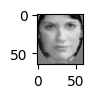

Imagen 004_1923_ID0_1.jpg cargada usando PIL.
Imagen 03345_ID0_1.jpg cargada usando PIL.
Imagen 033_ID0_1.jpg cargada usando PIL.
Imagen 039_10903_ID0_1.jpg cargada usando PIL.
Imagen 039_14967_ID0_1.jpg cargada usando PIL.
Imagen 039_16974_ID0_1.jpg cargada usando PIL.
Imagen 039_18456_ID0_1.jpg cargada usando PIL.
Imagen 039_18670_ID0_1.jpg cargada usando PIL.
Imagen 039_19477_ID0_1.jpg cargada usando PIL.
Imagen 039_23101_ID0_1.jpg cargada usando PIL.
Imagen 039_23581_ID0_1.jpg cargada usando PIL.
Imagen 039_24196_ID0_1.jpg cargada usando PIL.
Imagen 039_28488_ID0_1.jpg cargada usando PIL.
Imagen 039_30218_ID0_1.jpg cargada usando PIL.
Imagen 039_30555_ID0_1.jpg cargada usando PIL.
Imagen 039_30929_ID0_1.jpg cargada usando PIL.
Imagen 039_31850_ID0_1.jpg cargada usando PIL.
Imagen 039_32989_ID0_1.jpg cargada usando PIL.
Imagen 039_33085_ID0_1.jpg cargada usando PIL.
Imagen 039_33723_ID0_1.jpg cargada usando PIL.
Imagen 039_34455_ID0_1.jpg cargada usando PIL.
Imagen 039_35109_ID0_1.j

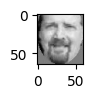

Imagen 002_822_ID0_1.jpg cargada usando PIL.
Imagen 0102051841300_ID0_1.jpg cargada usando PIL.
Imagen 0102051959100_ID0_1.jpg cargada usando PIL.
Imagen 015928500_ID0_1.jpg cargada usando PIL.
Imagen 01b_ID0_1.jpg cargada usando PIL.
Imagen 039_12682_ID0_1.jpg cargada usando PIL.
Imagen 039_16626_ID0_1.jpg cargada usando PIL.
Imagen 039_19685_ID0_1.jpg cargada usando PIL.
Imagen 039_20549_ID0_1.jpg cargada usando PIL.
Imagen 039_20811_ID0_1.jpg cargada usando PIL.
Imagen 039_20812_ID0_1.jpg cargada usando PIL.
Imagen 039_22821_ID0_1.jpg cargada usando PIL.
Imagen 039_25361_ID0_1.jpg cargada usando PIL.
Imagen 039_26768_ID0_1.jpg cargada usando PIL.
Imagen 039_26914_ID0_1.jpg cargada usando PIL.
Imagen 039_34584_ID0_1.jpg cargada usando PIL.
Imagen 039_34633_ID0_1.jpg cargada usando PIL.
Imagen 039_36626_ID0_1.jpg cargada usando PIL.
Imagen 039_36726_ID0_1.jpg cargada usando PIL.
Imagen 039_39117_ID0_1.jpg cargada usando PIL.
Imagen 039_39617_ID0_1.jpg cargada usando PIL.
Imagen 039_39

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Modificar con la ruta de tu equipo tras descargar los datos del campus
folder = "C:\\Users\\aleja\\OneDrive\\Documentos\\VC_Practicas_Alejandro_Rodriguez_Mesa\\VC_Practicas_Alejandro_Rodriguez_Mesa\\Practicas-VC-Alejandro_RodríguezMesa\\Pract_5_Alejandro_Rodriguez_Mesa\\DatabaseGender59x65\\DatabaseGender59x65"

# Contador de número de clases del conjunto
nclasses = 0
# Contador de muestras por clase
nperclass = []
# Etiqueta de cada clase (nombre de la subcarpeta)
classlabels = []
# Inicializa estructuras de datos y sus correpondientes etiquetas
X = []
Y = []

# Valor de resolución por defecto de matplotlib
dpi = plt.rcParams['figure.dpi']

# Asume que en la ruta indicada hay una subcarpeta por clase
for class_name in os.listdir(folder):
    # Cada subcarpeta implica una clase más
    nclasses += 1
    # Inicialmente esta clase no tiene muestras
    nsamples = 0

    # Compone la ruta
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Asume imágenes en formato jpg
        if file_name.endswith('.jpg'):
            # Lee la imagen con OpenCV
            image_path = os.path.join(class_folder, file_name)
            image = cv2.imread(image_path)
            
            # Si no se puede leer con OpenCV, intenta con PIL
            if image is None:
                try:
                    with Image.open(image_path) as img:
                        # Convierte la imagen a modo RGB y luego a formato compatible con OpenCV
                        image = cv2.cvtColor(np.array(img.convert('RGB')), cv2.COLOR_RGB2BGR)
                        print(f"Imagen {file_name} cargada usando PIL.")
                except Exception as e:
                    print(f"Error al leer la imagen {image_path} con PIL. {e}")
                    continue
            
            # Extrae tamaños
            height, width, depth = image.shape
            # Convierte a escala de grises
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Añade a X, previa conversión en vector
            X.append(gray.reshape(height * width))
            # Añade etiqueta numérica de la muestra
            Y.append(nclasses - 1)
            # Muestra primera imagen de la clase
            if nsamples == 0:
                figsize = width / float(dpi), height / float(dpi)
                plt.figure(figsize=figsize)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
                plt.show()
            
            # Incrementa el número de muestras
            nsamples += 1
    nperclass.append(nsamples)
    classlabels.append(class_name)

# Convierte a numpy array X e Y
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='float64')

# Muestra datos del conjunto leído
n_samples, n_features = X.shape
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# features: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1])


### Division del conjunto en datos de entrenamiento y test

In [4]:
# Split into a train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

print("# samples in training set %d" % X_train.shape[0])
print("# samples in test set %d" % X_test.shape[0])

# samples in training set 795
# samples in test set 342


### Análisis de Componentes Principales (PCA) sobre el conjunto de entrenamiento

In [5]:
# Compute PCA on the training subset for n_comp components
print("PCA computation for .95 of the variance from %d faces..."
      % (X_train.shape[0]))
t0 = time()
pca_95 = PCA(.85).fit(X_train)
print("done in %0.3fs" % (time() - t0))
print("%d components selected" % (pca_95.n_components_ ))

eigenfaces_95 = pca_95.components_.reshape((pca_95.n_components_ , height, width))

print("Projecting training and test on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca_95 = pca_95.transform(X_train)
X_test_pca_95 = pca_95.transform(X_test)
print("done in %0.3fs" % (time() - t0))

PCA computation for .95 of the variance from 795 faces...
done in 7.643s
39 components selected
Projecting training and test on the eigenfaces orthonormal basis
done in 0.017s


### Entrenamiento de clasificados SVM

In [6]:
# Train a SVM classifier
# Data normalization according to training data before training
print("Normalization...")
scaler = MinMaxScaler()
train_X = scaler.fit_transform(X_train_pca_95)
test_X = scaler.transform(X_test_pca_95)

print("SVM training...")
t0 = time()
parameters = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
# Grid serach across parameter range
clf_pca_95 = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), parameters, cv=5
)
clf_pca_95 = clf_pca_95.fit(train_X, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_pca_95.best_estimator_)


print("Predicting")
t0 = time()
y_pred = clf_pca_95.predict(test_X)
print("done in %0.3fs" % (time() - t0))

print("\nMetrics")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Precision:  %0.3f, Recall:  %0.3f" % ( precision_score(y_test, y_pred),recall_score(y_test, y_pred) )) 
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Normalization...
SVM training...
done in 11.496s
Best estimator found by grid search:
SVC(C=100000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.008s

Metrics
              precision    recall  f1-score   support

      Female       0.90      0.84      0.87       185
        Male       0.83      0.89      0.86       157

    accuracy                           0.86       342
   macro avg       0.86      0.86      0.86       342
weighted avg       0.86      0.86      0.86       342

Precision:  0.827, Recall:  0.885
Confusion matrix
[[156  29]
 [ 18 139]]


### Probando predicciones

In [7]:
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

# Función para predecir el género de una imagen
def predecir_genero(imagen_path, clf, pca, scaler, height, width):
    # Lee la imagen
    imagen = cv2.imread(imagen_path)
    
    # Verifica si la imagen se leyó correctamente, sino intenta con PIL
    if imagen is None:
        try:
            with Image.open(imagen_path) as img:
                imagen = cv2.cvtColor(np.array(img.convert('RGB')), cv2.COLOR_RGB2BGR)
                print("Imagen cargada usando PIL.")
        except Exception as e:
            print(f"Error al leer la imagen con PIL: {e}")
            return

    # Convierte a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Redimensiona si es necesario (aquí se asume tamaño específico)
    gray = cv2.resize(gray, (width, height))
    
    # Convierte la imagen en vector
    vector = gray.reshape(1, height * width)
    
    # Aplica PCA
    vector_pca = pca.transform(vector)
    
    # Normaliza
    vector_norm = scaler.transform(vector_pca)
    
    # Predice el género
    prediccion = clf.predict(vector_norm)
    
    # Traduce la predicción a una etiqueta
    genero = "Mujer" if prediccion[0] == 0 else "Hombre"  # Ajusta según tu clase (0: Mujer, 1: Hombre)
    
    # Imprime el resultado
    print(f"La predicción para la imagen '{imagen_path}' es: {genero}")

# Ejemplo de uso:
print("----------HOMBRES---------------")
for i in range(1,11):
    imagen_path = "images/"+ str(i)+"h.jpg"  # Reemplaza con la ruta a la imagen que deseas probar
    predecir_genero(imagen_path, clf_pca_95, pca_95, scaler, height, width)
print("6/10")
print("----------MUJERES---------------")
for i in range(1,11):
    imagen_path = "images/"+ str(i)+"m.jpg"  # Reemplaza con la ruta a la imagen que deseas probar
    predecir_genero(imagen_path, clf_pca_95, pca_95, scaler, height, width)
print("5/10")

----------HOMBRES---------------
La predicción para la imagen 'images/1h.jpg' es: Hombre
La predicción para la imagen 'images/2h.jpg' es: Hombre
La predicción para la imagen 'images/3h.jpg' es: Hombre
La predicción para la imagen 'images/4h.jpg' es: Hombre
La predicción para la imagen 'images/5h.jpg' es: Mujer
La predicción para la imagen 'images/6h.jpg' es: Mujer
La predicción para la imagen 'images/7h.jpg' es: Mujer
La predicción para la imagen 'images/8h.jpg' es: Mujer
La predicción para la imagen 'images/9h.jpg' es: Hombre
La predicción para la imagen 'images/10h.jpg' es: Hombre
6/10
----------MUJERES---------------
La predicción para la imagen 'images/1m.jpg' es: Mujer
La predicción para la imagen 'images/2m.jpg' es: Hombre
La predicción para la imagen 'images/3m.jpg' es: Mujer
La predicción para la imagen 'images/4m.jpg' es: Mujer
La predicción para la imagen 'images/5m.jpg' es: Hombre
La predicción para la imagen 'images/6m.jpg' es: Hombre
La predicción para la imagen 'images/7m

## Filtro Pikachu + Detección de género

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pygame
import threading
import random
import math
import time

class Coord:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # ... [Métodos de la clase Coord sin cambios]

    def __sub__(self, other):
        return Coord(self.x - other.x, self.y - other.y)

    def __add__(self, other):
        return Coord(self.x + other.x, self.y + other.y)

    def __mul__(self, factor):
        return Coord(self.x * factor, self.y * factor)

    def __rmul__(self, factor):
        return self.__mul__(factor)

    def __truediv__(self, factor):
        return Coord(self.x / factor, self.y / factor)

    def length(self):
        return math.hypot(self.x, self.y)

    def angle(self):
        return math.atan2(self.y, self.x)

    def normalize(self):
        length = self.length()
        if length == 0:
            return Coord(0, 0)
        return self / length

def rotate_counter_clockwise(coord, rad_angle):
    cos_theta = math.cos(rad_angle)
    sin_theta = math.sin(rad_angle)
    return Coord(
        coord.x * cos_theta - coord.y * sin_theta,
        coord.x * sin_theta + coord.y * cos_theta
    )

def generate_single_bolt(origin, tail):
    segments = [(origin, tail)]
    offset = MAX_OFFSET
    length = (tail - origin).length()
    refinement_limit = int(length / 50)
    branch_probability = 0.2
    branch_segments = []

    for _ in range(refinement_limit):
        new_segments = []
        for segment in segments:
            start, end = segment
            mid = (start + end) / 2
            direction = (end - start).normalize()
            perpendicular = rotate_counter_clockwise(direction, math.pi / 2)

            displacement = random.uniform(-offset, offset)
            mid += perpendicular * displacement

            new_segments.append((start, mid))
            new_segments.append((mid, end))

            if random.random() < branch_probability:
                branch_dir = rotate_counter_clockwise(direction, random.uniform(-math.pi / 2, math.pi / 2))
                branch_length = length * random.uniform(0.1, 0.3)
                branch_end = mid + branch_dir * branch_length
                branch_segments.append((mid, branch_end))

        segments = new_segments
        offset /= 1.5

    all_segments = segments + branch_segments
    return all_segments

# Parámetros de los rayos
FEMALE_LIGHTNING_COLOR = (148, 0, 211)
DEFAULT_LIGHTNING_COLOR = (250, 251, 165)  # Ajusta a otro color de rayo si lo deseas
BOLT_WIDTH = 4
FLASH_PROBABILITY = 0.9
MAX_OFFSET = 50
TAIL_LENGTH = 200

def draw_lightnings(frame, origin, tail):
    LIGHTNING_COLOR = FEMALE_LIGHTNING_COLOR if genero_predicho == "Mujer" else DEFAULT_LIGHTNING_COLOR
    if random.random() < FLASH_PROBABILITY:
        bolt_segments = generate_single_bolt(origin, tail)
        for segment in bolt_segments:
            start_pt = (int(segment[0].x), int(segment[0].y))
            end_pt = (int(segment[1].x), int(segment[1].y))
            height, width = frame.shape[:2]
            if 0 <= start_pt[0] < width and 0 <= start_pt[1] < height and 0 <= end_pt[0] < width and 0 <= end_pt[1] < height:
                cv2.line(frame, start_pt, end_pt, LIGHTNING_COLOR, BOLT_WIDTH)





# Inicializamos MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Inicializar Pygame mixer
pygame.mixer.init()

pika_sound = pygame.mixer.Sound('sounds/pika_sound.mp3')
is_playing_sound = False

def play_sound():
    global is_playing_sound
    if not is_playing_sound:
        is_playing_sound = True
        threading.Thread(target=lambda: pika_sound.play()).start()

        def reset_flag():
            global is_playing_sound
            pygame.time.delay(int(pika_sound.get_length() * 1000))
            is_playing_sound = False

        threading.Thread(target=reset_flag).start()


def overlay_image_alpha(img, img_overlay, x, y):
    """Superpone img_overlay sobre img en la posición (x, y) utilizando el canal alfa."""
    # Rango de imágenes
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]

    # Si no hay canal alfa, se crea uno
    if img_overlay_crop.shape[2] < 4:
        img_overlay_crop = np.concatenate(
            [img_overlay_crop,
             np.ones((img_overlay_crop.shape[0], img_overlay_crop.shape[1], 1), dtype=img_overlay_crop.dtype) * 255],
            axis=2,
        )

    alpha_overlay = img_overlay_crop[:, :, 3] / 255.0
    alpha_background = 1.0 - alpha_overlay

    for c in range(0, 3):
        img_crop[:, :, c] = (
            alpha_overlay * img_overlay_crop[:, :, c] +
            alpha_background * img_crop[:, :, c]
        )

def rotate_image(image, angle):
    """Rota una imagen con el ángulo dado manteniendo el tamaño."""
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))
    return rotated

genero_predicho = None
genero_recalculado = False  # Para saber si ya se hizo la predicción de género
def predecir_genero(imagen, clf, pca, scaler, height, width):
    # Convierte la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (width, height))
    
    # Convierte la imagen en vector
    vector = gray.reshape(1, height * width)
    
    # Aplica PCA y normalización
    vector_pca = pca.transform(vector)
    vector_norm = scaler.transform(vector_pca)
    
    # Predice el género (0: Mujer, 1: Hombre)
    prediccion = clf.predict(vector_norm)
    return "Mujer" if prediccion[0] == 0 else "Hombre"

# Cargar las imágenes de las orejas con canal alfa
left_ear_img = cv2.imread('images/pika_left_ear.png', cv2.IMREAD_UNCHANGED)
right_ear_img = cv2.imread('images/pika_right_ear.png', cv2.IMREAD_UNCHANGED)
SCALE_FACTOR = 2.5 

# Variables globales para almacenar las mediciones iniciales y estado
initial_measurements = {
    'face_height': None,
    'face_width': None,
    'mouth_distance': None
}

measurement_frames = 60  # Número de frames para medir
frame_counter = 0
mofletes_inflados = False
last_measurement_time = time.time()
measurement_interval = 10  # Recalcular cada 10 segundos
recalculating = True  # Estado inicial de recalculación

def process_frame(frame, face_mesh, clf, pca, scaler, height, width):
    global frame_counter, initial_measurements, mofletes_inflados, last_measurement_time, recalculating
    global genero_predicho, genero_recalculado  # Asegurarse de que sean variables globales

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)
    points_data = {}

    current_time = time.time()
    time_since_last_measurement = current_time - last_measurement_time
    time_until_next_measurement = measurement_interval - time_since_last_measurement

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            h, w, _ = frame.shape
            x_min, x_max = w, 0
            y_min, y_max = h, 0

            for id, landmark in enumerate(face_landmarks.landmark):
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)
            
            face_frame = frame[y_min:y_max, x_min:x_max]

            # Mostrar la malla facial durante la recalibración
            if recalculating or not genero_recalculado:
                # Predice el género en el área de la cara detectada
                genero_predicho = predecir_genero(face_frame, clf, pca, scaler, height, width)
                
                genero_recalculado = True  # Evita repetir la predicción hasta la próxima recalibración
            
                # Dibuja la malla facial
                mp_drawing.draw_landmarks(
                    image=frame,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
                )
            
            # Escribir el género detectado sobre la imagen
            cv2.putText(frame, genero_predicho, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Puntos clave
            points = [10, 152, 93, 323, 13, 14, 67, 103, 297, 332, 54, 284, 205, 425, 4, 98, 327, 33, 263, 1, 
                    30, 29, 27, 257, 259, 260]            
            for point in points:
                if point < len(face_landmarks.landmark):
                    x = face_landmarks.landmark[point].x
                    y = face_landmarks.landmark[point].y

                    x_pixel = int(x * frame.shape[1])
                    y_pixel = int(y * frame.shape[0])

                    points_data[point] = {'x': x_pixel, 'y': y_pixel}

            required_points = [10, 152, 93, 323, 13, 14]

            if all(point in points_data for point in required_points):
                # Calcular medidas
                y_top = points_data[10]['y']
                y_bottom = points_data[152]['y']
                face_height = abs(y_bottom - y_top)

                x_left = points_data[93]['x']
                x_right = points_data[323]['x']
                face_width = abs(x_right - x_left)

                mouth_top = points_data[13]
                mouth_bottom = points_data[14]
                mouth_distance = np.linalg.norm(
                    np.array([mouth_top['x'], mouth_top['y']]) -
                    np.array([mouth_bottom['x'], mouth_bottom['y']])
                )

                # Recalibración de medidas
                if recalculating:
                    frame_counter += 1
                    if initial_measurements['face_height'] is None:
                        initial_measurements['face_height'] = face_height
                        initial_measurements['face_width'] = face_width
                        initial_measurements['mouth_distance'] = mouth_distance
                    else:
                        # Promediar las mediciones iniciales
                        initial_measurements['face_height'] = (initial_measurements['face_height'] * (frame_counter - 1) + face_height) / frame_counter
                        initial_measurements['face_width'] = (initial_measurements['face_width'] * (frame_counter - 1) + face_width) / frame_counter
                        initial_measurements['mouth_distance'] = (initial_measurements['mouth_distance'] * (frame_counter - 1) + mouth_distance) / frame_counter

                    # Mostrar texto de escaneo
                    cv2.putText(frame, f"Escaneando rostro... {measurement_frames - frame_counter}", (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                    if frame_counter >= measurement_frames:
                        recalculating = False
                        frame_counter = 0
                        last_measurement_time = time.time()
                else:
                    # Comparar mediciones actuales con las iniciales
                    height_ratio = face_height / initial_measurements['face_height']
                    width_ratio = face_width / initial_measurements['face_width']
                    mouth_ratio = mouth_distance / initial_measurements['mouth_distance']

                    # Umbrales para detectar mofletes inflados
                    height_threshold = 0.98
                    width_threshold = 1.01
                    mouth_threshold = 0.98

                    if width_ratio >= width_threshold and mouth_ratio <= mouth_threshold and height_ratio <= height_threshold:
                        mofletes_inflados = True
                    else:
                        mofletes_inflados = False

                    # Mostrar contador regresivo para próxima recalibración
                    if time_until_next_measurement <= 0:
                        recalculating = True
                        genero_recalculado = False  # Resetea para la próxima predicción de género
                        initial_measurements = {'face_height': None, 'face_width': None, 'mouth_distance': None}
                        frame_counter = 0
                        last_measurement_time = current_time
                    else:
                        cv2.putText(frame, f"Recalibracion en: {int(time_until_next_measurement)}s", (50, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Comprobar si la boca está abierta para reproducir el sonido
            if 13 in points_data and 14 in points_data:
                mouth_top = points_data[13]
                mouth_bottom = points_data[14]
                mouth_distance = np.linalg.norm(
                    np.array([mouth_top['x'], mouth_top['y']]) -
                    np.array([mouth_bottom['x'], mouth_bottom['y']])
                )

                if mouth_distance > 15:
                    play_sound()

            # Nariz
            if 4 in points_data and 98 in points_data and 327 in points_data:
                pt1 = (points_data[4]['x'], points_data[4]['y'])
                pt2 = (points_data[327]['x'], points_data[327]['y'])
                pt3 = (points_data[98]['x'], points_data[98]['y'])

                triangle_cnt = np.array([pt1, pt2, pt3])
                cv2.fillPoly(frame, [triangle_cnt], (0, 0, 0))

                line_thickness = 10
                color = (0, 0, 0)

                cv2.line(frame, pt1, pt2, color, thickness=line_thickness, lineType=cv2.LINE_8)
                cv2.line(frame, pt2, pt3, color, thickness=line_thickness, lineType=cv2.LINE_8)
                cv2.line(frame, pt3, pt1, color, thickness=line_thickness, lineType=cv2.LINE_8)

                radius = line_thickness // 2
                cv2.circle(frame, pt1, radius, color, thickness=-1, lineType=cv2.LINE_8)
                cv2.circle(frame, pt2, radius, color, thickness=-1, lineType=cv2.LINE_8)
                cv2.circle(frame, pt3, radius, color, thickness=-1, lineType=cv2.LINE_8)

            # Calcular ángulo de la cara
            if all(k in points_data for k in [33, 263]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))
            else:
                face_angle = 0  # Valor por defecto si no se puede calcular

            # Orejas
            # Calcular ángulo de la cara usando los puntos de los ojos exteriores
            if all(k in points_data for k in [33, 263]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))

            # Orejas: Calcula la posición y rotación
            if all(k in points_data for k in [33, 263, 1, 10, 152]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                face_width = np.linalg.norm(right_eye_outer - left_eye_outer)
                face_height = abs(points_data[152]['y'] - points_data[10]['y'])

                # Tamaño y desplazamiento de las orejas
                ear_size = int(face_width * 0.8)
                ear_size = max(50, min(ear_size, 200))  # Límite del tamaño

                # Redimensionar y rotar imágenes de las orejas
                left_ear_resized = cv2.resize(left_ear_img, (ear_size, ear_size), interpolation=cv2.INTER_AREA)
                right_ear_resized = cv2.resize(right_ear_img, (ear_size, ear_size), interpolation=cv2.INTER_AREA)
                left_ear_rotated = rotate_image(left_ear_resized, face_angle)
                right_ear_rotated = rotate_image(right_ear_resized, face_angle)

                # Calcula posiciones ajustadas para las orejas basadas en la inclinación de la cabeza
                ear_offset_y = face_height * 0.5  # desplazamiento de las orejas sobre los ojos
                left_ear_pos = left_eye_outer + np.array([0, -ear_offset_y])
                right_ear_pos = right_eye_outer + np.array([0, -ear_offset_y])

                # Superponer las orejas en el frame
                overlay_image_alpha(frame, left_ear_rotated, int(left_ear_pos[0] - ear_size / 2), int(left_ear_pos[1] - ear_size / 2))
                overlay_image_alpha(frame, right_ear_rotated, int(right_ear_pos[0] - ear_size / 2), int(right_ear_pos[1] - ear_size / 2))


            # Mofletes
            if 205 in points_data and 425 in points_data and 33 in points_data and 263 in points_data:
                x1_cheek, y1_cheek = points_data[205]['x'], points_data[205]['y']
                x2_cheek, y2_cheek = points_data[425]['x'], points_data[425]['y']

                cheek_distance = np.sqrt((x2_cheek - x1_cheek) ** 2 + (y2_cheek - y1_cheek) ** 2)
                ellipse_axes = (int(cheek_distance / 8), int(cheek_distance / 16))  # ancho, alto

                # Obtener ángulo de la cara
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))

                cv2.ellipse(frame, (x1_cheek, y1_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 255), -1)
                cv2.ellipse(frame, (x1_cheek, y1_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 0), 2)

                cv2.ellipse(frame, (x2_cheek, y2_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 255), -1)
                cv2.ellipse(frame, (x2_cheek, y2_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 0), 2)

                if mofletes_inflados:
                    origin_right = Coord(x1_cheek, y1_cheek)
                    tail_right = Coord(x1_cheek + TAIL_LENGTH, y1_cheek + TAIL_LENGTH)
                    draw_lightnings(frame, origin_right, tail_right)

                    origin_left = Coord(x2_cheek, y2_cheek)
                    tail_left = Coord(x2_cheek - TAIL_LENGTH, y2_cheek + TAIL_LENGTH)
                    draw_lightnings(frame, origin_left, tail_left)
            if genero_predicho == "Mujer":
                # Ojo derecho: puntos 30, 29, 27
                for idx in [30, 29, 27]:
                    if idx in points_data:
                        start_point = (points_data[idx]['x'], points_data[idx]['y'])
                        end_point = (start_point[0] - 5, start_point[1] - 10)  # Ajuste para ojo derecho
                        cv2.line(frame, start_point, end_point, (0, 0, 0), 2, cv2.LINE_AA)

                # Ojo izquierdo: puntos 257, 259, 260
                for idx in [257, 259, 260]:
                    if idx in points_data:
                        start_point = (points_data[idx]['x'], points_data[idx]['y'])
                        end_point = (start_point[0] + 5, start_point[1] - 10)  # Ajuste para ojo izquierdo
                        cv2.line(frame, start_point, end_point, (0, 0, 0), 2, cv2.LINE_AA)

    return frame

def main():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

    if not cap.isOpened():
        print("No se puede abrir la cámara")
        exit()

    with mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)

            frame_processed = process_frame(frame, face_mesh, clf_pca_95, pca_95, scaler, height, width)

            cv2.imshow('Frame', frame_processed)

            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('p'):
                play_sound()

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


pygame 2.6.1 (SDL 2.28.4, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'clf_pca_95' is not defined

## Detección de emociones

### Procesamiento de datos, extrayendo landmarks y entrenando el modelo

In [13]:
import os 
import cv2
import pickle
import mediapipe as mp
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

No face detected in ./emotions/train\angry\Training_10131352.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_10333072.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_10485618.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_10882484.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_10922970.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_11579481.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_11808005.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_12037449.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_12148960.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_12250673.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_12661221.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_13043913.jpg. Skipping...
No face detected in ./emotions/train\angry\Training_13852029.jpg

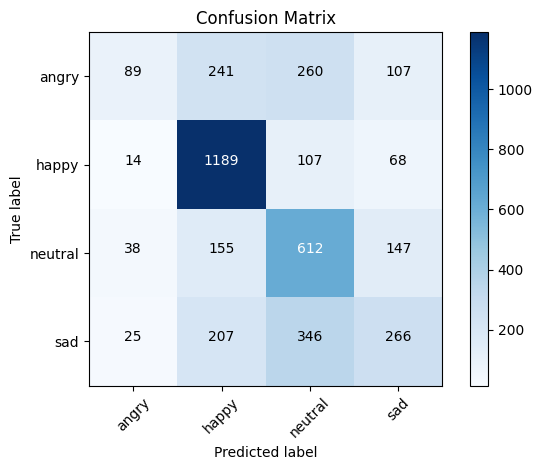

Classification Accuracy: 55.70%

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.13      0.21       697
           1       0.66      0.86      0.75      1378
           2       0.46      0.64      0.54       952
           3       0.45      0.32      0.37       844

    accuracy                           0.56      3871
   macro avg       0.53      0.49      0.47      3871
weighted avg       0.54      0.56      0.52      3871



In [ ]:


def gather_landmark_data(directory):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    
    landmark_data = {}
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to read image {img_path}. Skipping...")
                    continue
                # Redimensionar la imagen a 192x192
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_rgb = cv2.resize(img_rgb, (192, 192))
                results = face_mesh.process(img_rgb)
                
                if results.multi_face_landmarks:
                    landmarks = results.multi_face_landmarks[0]
                    coords = [(landmark.x, landmark.y, landmark.z) for landmark in landmarks.landmark]
                    landmark_data[img_path] = coords
                else:
                    print(f"No face detected in {img_path}. Skipping...")
    
    face_mesh.close()
    return landmark_data

def save_landmark_data(landmark_data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(landmark_data, f)

# Directorio para las imágenes de entrenamiento
train_directory = './emotions/train'
landmark_data = gather_landmark_data(train_directory)
save_landmark_data(landmark_data, './mp_landmark_data.pkl')

# Cargar los datos de landmarks guardados
def load_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def convert_dict_to_arrays(data_dict):
    data = []
    labels = []
    for img_path, landmarks in data_dict.items():
        data.append(np.array(landmarks).flatten())
        # Usar os.path para extraer la etiqueta correctamente
        labels.append(os.path.basename(os.path.dirname(img_path)))
    return np.asarray(data), np.asarray(labels)

def split_data(data, labels, test_size=0.2):
    return train_test_split(data, labels, test_size=test_size, shuffle=True, stratify=labels)

# Configuración de GridSearch para hiperparámetros de XGBoost
def tune_hyperparameters(x_train, y_train):
    num_classes = len(np.unique(y_train))
    param_grid = {
        'learning_rate': [0.05],  # Reducir para acelerar
        'n_estimators': [100],    # Reducir para acelerar
        'max_depth': [3],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'tree_method': ['hist'],
    }
    xgb = XGBClassifier(
        objective='multi:softprob', 
        eval_metric='mlogloss', 
        n_jobs=1, 
        random_state=42,
        num_class=num_classes
    )
    grid_search = GridSearchCV(
        estimator=xgb, 
        param_grid=param_grid, 
        cv=3, 
        n_jobs=1, 
        verbose=2, 
        scoring='accuracy'
    )
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_

def evaluate_model(model, x_test, y_test):
    y_predict = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_predict)
    report = classification_report(y_test, y_predict, zero_division=0)
    matrix = confusion_matrix(y_test, y_predict)
    return accuracy, report, matrix

# Función para plotear la matriz de confusión
def plot_confusion_matrix(matrix, labels):
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'), horizontalalignment="center",
                 color="white" if matrix[i, j] > matrix.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Ejecución principal
data_dict = load_data('./mp_landmark_data.pkl')
data, labels = convert_dict_to_arrays(data_dict)

# Imprimir etiquetas y recuentos
unique_labels, counts = np.unique(labels, return_counts=True)
print('Labels and counts:', dict(zip(unique_labels, counts)))

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
label_classes = label_encoder.classes_

print('Label classes:', label_classes)

x_train, x_test, y_train, y_test = split_data(data, labels_encoded)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

best_model = tune_hyperparameters(x_train, y_train)
accuracy, report, matrix = evaluate_model(best_model, x_test, y_test)

# Mostrar resultados
plot_confusion_matrix(matrix, label_classes)
plt.show()
print(f"Classification Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:\n", report)

# Guardar el modelo entrenado
with open('./mp_model.pkl', 'wb') as f:
    pickle.dump({'model': best_model, 'label_classes': label_classes}, f)


## Prediccion con el conjunto test

No face detected in ./emotions/test\angry\PrivateTest_10304478.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_1054527.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_10590091.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_1109992.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_11296953.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_13278552.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_13541561.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_17952984.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_19777137.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_20789399.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_21042434.jpg. Skipping...
No face detected in ./emotions/test\angry\PrivateTest_26784100.jpg. Skipping...
No face detected in ./emotions/test\angry\

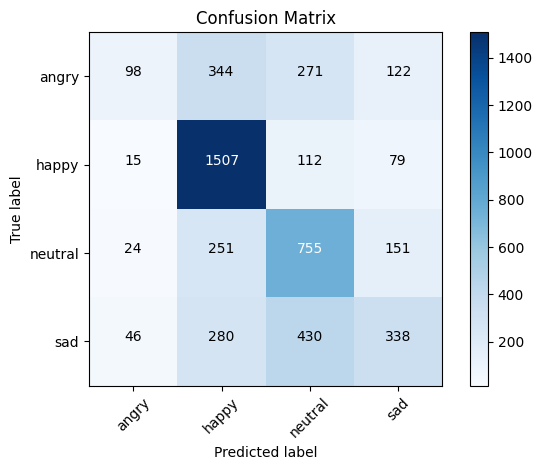

In [10]:
import os
import pickle
import cv2
import numpy as np
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

def initialize_model():
    with open('./mp_model.pkl', 'rb') as f:
        model_data = pickle.load(f)
    return model_data['model'], model_data['label_classes']

def predict_expression(img_path, clf, facemesh):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image {img_path}. Skipping...")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = facemesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        print(f"No face detected in {img_path}. Skipping...")
        return None

    landmark_data = []
    for landmark in results.multi_face_landmarks[0].landmark:
        landmark_data.extend([landmark.x, landmark.y, landmark.z])

    prediction_index = clf.predict([landmark_data])[0]
    return prediction_index

def evaluate_on_test_set(test_directory, clf, facemesh, label_classes):
    y_true = []
    y_pred = []

    for class_name in os.listdir(test_directory):
        class_dir = os.path.join(test_directory, class_name)
        if os.path.isdir(class_dir):  # Verificar que sea un directorio
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                
                # Predicción de la expresión de la imagen
                prediction_index = predict_expression(img_path, clf, facemesh)
                if prediction_index is not None:
                    y_true.append(class_name)  # Etiqueta verdadera basada en el nombre de la carpeta
                    y_pred.append(label_classes[prediction_index])  # Etiqueta predicha

    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, labels):
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'), horizontalalignment="center",
                 color="white" if matrix[i, j] > matrix.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Inicializar el modelo y MediaPipe
clf, label_classes = initialize_model()
facemesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

# Evaluar el modelo en el conjunto de pruebas
test_directory = './emotions/test'
y_true, y_pred = evaluate_on_test_set(test_directory, clf, facemesh, label_classes)

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_classes))
plot_confusion_matrix(y_true, y_pred, labels=label_classes)


### Prediccion en imagenes.

In [14]:
def initialize_model():
    with open('./mp_model.pkl', 'rb') as f:
        model_data = pickle.load(f)
    return model_data['model'], model_data['label_classes']

def predict_expression(img_path, clf, facemesh, label_classes):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = facemesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        print(f"No face detected in {img_path}.")
        return

    landmark_data = []
    for landmark in results.multi_face_landmarks[0].landmark:
        landmark_data.extend([landmark.x, landmark.y, landmark.z])

    prediction_index = clf.predict([landmark_data])[0]
    confidence = np.max(clf.predict_proba([landmark_data]))
    prediction_expression = label_classes[prediction_index].capitalize()

    print(f"Prediction: {prediction_expression} (Confidence: {confidence*100:.2f}%)")
    
# Inicializar modelo y MediaPipe
clf, label_classes = initialize_model()
facemesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

# Prueba de predicciones con nuevas imágenes
predict_expression('./images/1h.jpg', clf, facemesh, label_classes)
predict_expression('./images/3m.jpg', clf, facemesh, label_classes)


Prediction: Happy (Confidence: 43.31%)
Prediction: Sad (Confidence: 40.45%)


## Filtro pikachu + Detector de Género + Detector de Emoción

El filtro de pikachu y el detector de género se mantuvo igual. Para el detector de emociones, cuando la cara detectada es triste se le añade un gif de lluvia sin fondo con la libreria imageio para mostrarlo con fondo transpatenet. 

In [8]:
import cv2
import mediapipe as mp
import numpy as np
import pygame
import threading
import random
import math
import time
import pickle
import imageio
from PIL import Image, ImageSequence  # Importamos PIL para manejar mejor las transparencias


#------------- Rayos-----------------
class Coord:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # ... [Métodos de la clase Coord sin cambios]

    def __sub__(self, other):
        return Coord(self.x - other.x, self.y - other.y)

    def __add__(self, other):
        return Coord(self.x + other.x, self.y + other.y)

    def __mul__(self, factor):
        return Coord(self.x * factor, self.y * factor)

    def __rmul__(self, factor):
        return self.__mul__(factor)

    def __truediv__(self, factor):
        return Coord(self.x / factor, self.y / factor)

    def length(self):
        return math.hypot(self.x, self.y)

    def angle(self):
        return math.atan2(self.y, self.x)

    def normalize(self):
        length = self.length()
        if length == 0:
            return Coord(0, 0)
        return self / length

def rotate_counter_clockwise(coord, rad_angle):
    cos_theta = math.cos(rad_angle)
    sin_theta = math.sin(rad_angle)
    return Coord(
        coord.x * cos_theta - coord.y * sin_theta,
        coord.x * sin_theta + coord.y * cos_theta
    )

def generate_single_bolt(origin, tail):
    segments = [(origin, tail)]
    offset = MAX_OFFSET
    length = (tail - origin).length()
    refinement_limit = int(length / 50)
    branch_probability = 0.2
    branch_segments = []

    for _ in range(refinement_limit):
        new_segments = []
        for segment in segments:
            start, end = segment
            mid = (start + end) / 2
            direction = (end - start).normalize()
            perpendicular = rotate_counter_clockwise(direction, math.pi / 2)

            displacement = random.uniform(-offset, offset)
            mid += perpendicular * displacement

            new_segments.append((start, mid))
            new_segments.append((mid, end))

            if random.random() < branch_probability:
                branch_dir = rotate_counter_clockwise(direction, random.uniform(-math.pi / 2, math.pi / 2))
                branch_length = length * random.uniform(0.1, 0.3)
                branch_end = mid + branch_dir * branch_length
                branch_segments.append((mid, branch_end))

        segments = new_segments
        offset /= 1.5

    all_segments = segments + branch_segments
    return all_segments

# Parámetros de los rayos
FEMALE_LIGHTNING_COLOR = (148, 0, 211)
DEFAULT_LIGHTNING_COLOR = (250, 251, 165)  # Ajusta a otro color de rayo si lo deseas
BOLT_WIDTH = 4
FLASH_PROBABILITY = 0.9
MAX_OFFSET = 50
TAIL_LENGTH = 200

def draw_lightnings(frame, origin, tail):
    LIGHTNING_COLOR = FEMALE_LIGHTNING_COLOR if genero_predicho == "Mujer" else DEFAULT_LIGHTNING_COLOR
    if random.random() < FLASH_PROBABILITY:
        bolt_segments = generate_single_bolt(origin, tail)
        for segment in bolt_segments:
            start_pt = (int(segment[0].x), int(segment[0].y))
            end_pt = (int(segment[1].x), int(segment[1].y))
            height, width = frame.shape[:2]
            if 0 <= start_pt[0] < width and 0 <= start_pt[1] < height and 0 <= end_pt[0] < width and 0 <= end_pt[1] < height:
                cv2.line(frame, start_pt, end_pt, LIGHTNING_COLOR, BOLT_WIDTH)
#------------- Rayos-----------------

# Inicializamos MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


#-------------------Sonido----------------
# Inicializar Pygame mixer
pygame.mixer.init()

pika_sound = pygame.mixer.Sound('sounds/pika_sound.mp3')
is_playing_sound = False
is_playing_rayo = False

def play_sound():
    global is_playing_sound
    if not is_playing_sound:
        is_playing_sound = True
        threading.Thread(target=lambda: pika_sound.play()).start()

        def reset_flag():
            global is_playing_sound
            pygame.time.delay(int(pika_sound.get_length() * 1000))
            is_playing_sound = False

        threading.Thread(target=reset_flag).start()
sound_rayo = pygame.mixer.Sound('sounds/rayo.mp3')
def play_sound_rayo():
    global is_playing_rayo, is_song_paused
    if not is_playing_rayo:
        # Pausar la canción triste si está sonando
        if is_playing_sad_song and not is_song_paused:
            pause_sad_song()
        
        is_playing_rayo = True
        threading.Thread(target=lambda: sound_rayo.play()).start()

        def rayo_reset_flag():
            global is_playing_rayo
            pygame.time.delay(int(sound_rayo.get_length() * 1000))
            is_playing_rayo = False
            
            # Reanudar la canción triste si estaba en pausa
            if is_song_paused:
                play_or_resume_sad_song()

        threading.Thread(target=rayo_reset_flag).start()


sad_song = pygame.mixer.Sound('./sounds/sad-piano-loop-90bpm-136465.mp3')  # Ruta de la canción triste
is_playing_sad_song = False
is_song_paused = False  # Variable global para controlar la pausa de la canción

# Función para reproducir la canción triste
# Función para reproducir o reanudar la canción triste
def play_or_resume_sad_song():
    global is_playing_sad_song, is_song_paused
    if not is_playing_sad_song:
        is_playing_sad_song = True
        is_song_paused = False
        threading.Thread(target=lambda: sad_song.play(-1)).start()  # Reproduce en bucle
    elif is_song_paused:
        pygame.mixer.unpause()  # Reanuda la canción si está pausada
        is_song_paused = False

# Función para pausar la canción triste
def pause_sad_song():
    global is_song_paused
    if is_playing_sad_song and not is_song_paused:
        pygame.mixer.pause()  # Pausa la canción
        is_song_paused = True

def stop_sad_song():
    global is_playing_sad_song
    if is_playing_sad_song:
        sad_song.stop()
        is_playing_sad_song = False
        is_song_paused = False

#-------------------Sonido----------------


#----------------Identificar Género-----------------

genero_predicho = None
genero_recalculado = False  # Para saber si ya se hizo la predicción de género
def predecir_genero(imagen, clf, pca, scaler, height, width):
    # Convierte la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (width, height))
    
    # Convierte la imagen en vector
    vector = gray.reshape(1, height * width)
    
    # Aplica PCA y normalización
    vector_pca = pca.transform(vector)
    vector_norm = scaler.transform(vector_pca)
    
    # Predice el género (0: Mujer, 1: Hombre)
    prediccion = clf.predict(vector_norm)
    return "Mujer" if prediccion[0] == 0 else "Hombre"

#----------------Identificar Género-----------------




#----------------GIF LLuvia----------------------

def load_gif_with_transparency(file_path):
    frames = []
    with Image.open(file_path) as im:
        for frame in ImageSequence.Iterator(im):
            frame = frame.convert("RGBA")
            frame_np = np.array(frame)
            # Establecer el color de fondo (negro) como transparente
            r, g, b, a = cv2.split(frame_np)
            mask = (r == 0) & (g == 0) & (b == 0)
            a[mask] = 0
            frame_np = cv2.merge((r, g, b, a))
            frames.append(frame_np)
    return frames

rain_gif_frames = load_gif_with_transparency("./images/rain_gif.gif")

# Función para superponer el GIF de lluvia con transparencia en el frame
def overlay_gif_alpha(background, gif_frames, x, y):
    """Superpone el GIF en la posición (x, y) del fondo usando transparencia del canal alfa, redimensionando el GIF al tamaño del fondo."""
    # Selecciona el fotograma adecuado en función del tiempo actual
    frame_index = int(time.time() * 30) % len(gif_frames)
    gif_frame = gif_frames[frame_index]

    # Redimensionar el GIF al tamaño del video
    gif_frame_resized = cv2.resize(gif_frame, (background.shape[1], background.shape[0]), interpolation=cv2.INTER_AREA)

    # Extrae los canales de color y alfa
    overlay_rgb = gif_frame_resized[..., :3]
    alpha_mask = gif_frame_resized[..., 3] / 255.0

    # Asegúrate de que la región del fondo a superponer existe y se adapta al tamaño de gif_frame
    h, w = gif_frame_resized.shape[:2]
    if y + h > background.shape[0] or x + w > background.shape[1]:
        return

    # Selecciona la región de fondo donde el GIF se sobrepondrá
    background_region = background[y:y+h, x:x+w]

    # Ajusta cada canal del fondo usando el canal alfa
    for c in range(3):
        background_region[..., c] = (1 - alpha_mask) * background_region[..., c] + alpha_mask * overlay_rgb[..., c]

#----------------GIF LLuvia----------------------


#------------------------Emociones---------------------------------------

# Cargar el modelo de emociones
def initialize_emotion_model():
    with open('mp_model.pkl', 'rb') as f:
        model_data = pickle.load(f)
    return model_data['model'], model_data['label_classes']

# Inicializar el modelo de emociones
emotion_clf, emotion_label_classes = initialize_emotion_model()

current_emotion = None  # Variable global para rastrear la emoción actual

#------------------------Emociones---------------------------------------


def overlay_image_alpha(img, img_overlay, x, y):
    """Superpone img_overlay sobre img en la posición (x, y) utilizando el canal alfa."""
    # Rango de imágenes
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]

    # Si no hay canal alfa, se crea uno
    if img_overlay_crop.shape[2] < 4:
        img_overlay_crop = np.concatenate(
            [img_overlay_crop,
             np.ones((img_overlay_crop.shape[0], img_overlay_crop.shape[1], 1), dtype=img_overlay_crop.dtype) * 255],
            axis=2,
        )

    alpha_overlay = img_overlay_crop[:, :, 3] / 255.0
    alpha_background = 1.0 - alpha_overlay

    for c in range(0, 3):
        img_crop[:, :, c] = (
            alpha_overlay * img_overlay_crop[:, :, c] +
            alpha_background * img_crop[:, :, c]
        )

def rotate_image(image, angle):
    """Rota una imagen con el ángulo dado manteniendo el tamaño."""
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))
    return rotated



# Cargar las imágenes de las orejas con canal alfa
left_ear_img = cv2.imread('images/pika_left_ear.png', cv2.IMREAD_UNCHANGED)
right_ear_img = cv2.imread('images/pika_right_ear.png', cv2.IMREAD_UNCHANGED)
SCALE_FACTOR = 2.5 

# Variables globales para almacenar las mediciones iniciales y estado
initial_measurements = {
    'face_height': None,
    'face_width': None,
    'mouth_distance': None
}

measurement_frames = 60  # Número de frames para medir
frame_counter = 0
mofletes_inflados = False
last_measurement_time = time.time()
measurement_interval = 10  # Recalcular cada 10 segundos
recalculating = True  # Estado inicial de recalculación



def process_frame(frame, face_mesh, clf, pca, scaler, height, width, emotion_clf, emotion_label_classes):
    global frame_counter, initial_measurements, mofletes_inflados, last_measurement_time, recalculating
    global genero_predicho, genero_recalculado  # Asegurarse de que sean variables globales
    global current_emotion, is_playing_sad_song  # Agregar current_emotion e is_playing_sad_song como globales

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)
    points_data = {}

    current_time = time.time()
    time_since_last_measurement = current_time - last_measurement_time
    time_until_next_measurement = measurement_interval - time_since_last_measurement

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            h, w, _ = frame.shape
            x_min, x_max = w, 0
            y_min, y_max = h, 0

            for id, landmark in enumerate(face_landmarks.landmark):
                x = min(max(int(landmark.x * w), 0), w - 1)
                y = min(max(int(landmark.y * h), 0), h - 1)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)
            
            if x_min < x_max and y_min < y_max:
                face_frame = frame[y_min:y_max, x_min:x_max]
            else:
                face_frame = None
            landmark_data = []
            for landmark in face_landmarks.landmark:
                landmark_data.extend([landmark.x, landmark.y, landmark.z])
                # Asegurarse de que la longitud de landmark_data es la esperada
            if len(landmark_data) == 468 * 3:  # 468 landmarks con x, y, z
                # Realizar la predicción
                emotion_prediction_index = emotion_clf.predict([landmark_data])[0]
                emotion_confidence = np.max(emotion_clf.predict_proba([landmark_data]))
                emotion_label = emotion_label_classes[emotion_prediction_index]

                # Mostrar la emoción en el frame
                cv2.putText(frame, f"Emocion: {emotion_label} ({emotion_confidence*100:.2f}%)", (frame.shape[1] - 250, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)
                
                # Verificar si la emoción ha cambiado
                if emotion_label != current_emotion:
                    if current_emotion == 'sad':
                        pause_sad_song()  # Pausa la canción si la emoción anterior era "sad"
                    current_emotion = emotion_label


                # Reproducir o detener la canción según la emoción
                if emotion_label == "sad":
                    play_or_resume_sad_song()  # Reproduce o reanuda la canción si la emoción actual es "sad"
                    overlay_gif_alpha(frame, rain_gif_frames, 0, 0)
                else:
                    if is_playing_sad_song:
                        pause_sad_song()  # Pausar en lugar de detener si la emoción no es "sad"

            # Mostrar la malla facial durante la recalibración
            if recalculating or not genero_recalculado:
                # Predice el género en el área de la cara detectada
                if face_frame is not None and face_frame.size > 0:
                    genero_predicho = predecir_genero(face_frame, clf, pca, scaler, height, width)
                
                genero_recalculado = True  # Evita repetir la predicción hasta la próxima recalibración
            
                # Dibuja la malla facial
                mp_drawing.draw_landmarks(
                    image=frame,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
                )
            
            # Escribir el género detectado sobre la imagen
            cv2.putText(frame, genero_predicho, (frame.shape[1] - 250, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            # Puntos clave
            points = [10, 152, 93, 323, 13, 14, 67, 103, 297, 332, 54, 284, 205, 425, 4, 98, 327, 33, 263, 1, 
                    30, 29, 27, 257, 259, 260]            
            for point in points:
                if point < len(face_landmarks.landmark):
                    x = face_landmarks.landmark[point].x
                    y = face_landmarks.landmark[point].y

                    x_pixel = int(x * frame.shape[1])
                    y_pixel = int(y * frame.shape[0])

                    points_data[point] = {'x': x_pixel, 'y': y_pixel}

            required_points = [10, 152, 93, 323, 13, 14]

            if all(point in points_data for point in required_points):
                # Calcular medidas
                y_top = points_data[10]['y']
                y_bottom = points_data[152]['y']
                face_height = abs(y_bottom - y_top)

                x_left = points_data[93]['x']
                x_right = points_data[323]['x']
                face_width = abs(x_right - x_left)

                mouth_top = points_data[13]
                mouth_bottom = points_data[14]
                mouth_distance = np.linalg.norm(
                    np.array([mouth_top['x'], mouth_top['y']]) -
                    np.array([mouth_bottom['x'], mouth_bottom['y']])
                )

                # Recalibración de medidas
                if recalculating:
                    frame_counter += 1
                    if initial_measurements['face_height'] is None:
                        initial_measurements['face_height'] = face_height
                        initial_measurements['face_width'] = face_width
                        initial_measurements['mouth_distance'] = mouth_distance
                    else:
                        # Promediar las mediciones iniciales
                        initial_measurements['face_height'] = (initial_measurements['face_height'] * (frame_counter - 1) + face_height) / frame_counter
                        initial_measurements['face_width'] = (initial_measurements['face_width'] * (frame_counter - 1) + face_width) / frame_counter
                        initial_measurements['mouth_distance'] = (initial_measurements['mouth_distance'] * (frame_counter - 1) + mouth_distance) / frame_counter

                    # Mostrar texto de escaneo
                    cv2.putText(frame, f"Escaneando rostro... {measurement_frames - frame_counter}", (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                    if frame_counter >= measurement_frames:
                        recalculating = False
                        frame_counter = 0
                        last_measurement_time = time.time()
                else:
                    # Comparar mediciones actuales con las iniciales
                    height_ratio = face_height / initial_measurements['face_height']
                    width_ratio = face_width / initial_measurements['face_width']
                    mouth_ratio = mouth_distance / initial_measurements['mouth_distance']

                    # Umbrales para detectar mofletes inflados
                    height_threshold = 0.98
                    width_threshold = 1.01
                    mouth_threshold = 0.98

                    if width_ratio >= width_threshold and mouth_ratio <= mouth_threshold and height_ratio <= height_threshold:
                        mofletes_inflados = True
                    else:
                        mofletes_inflados = False

                    # Mostrar contador regresivo para próxima recalibración
                    if time_until_next_measurement <= 0:
                        recalculating = True
                        genero_recalculado = False  # Resetea para la próxima predicción de género
                        initial_measurements = {'face_height': None, 'face_width': None, 'mouth_distance': None}
                        frame_counter = 0
                        last_measurement_time = current_time
                    else:
                        cv2.putText(frame, f"Recalibracion en: {int(time_until_next_measurement)}s", (50, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Comprobar si la boca está abierta para reproducir el sonido
            if 13 in points_data and 14 in points_data:
                mouth_top = points_data[13]
                mouth_bottom = points_data[14]
                mouth_distance = np.linalg.norm(
                    np.array([mouth_top['x'], mouth_top['y']]) -
                    np.array([mouth_bottom['x'], mouth_bottom['y']])
                )

                if mouth_distance > 15:
                    play_sound()

            # Nariz
            if 4 in points_data and 98 in points_data and 327 in points_data:
                pt1 = (points_data[4]['x'], points_data[4]['y'])
                pt2 = (points_data[327]['x'], points_data[327]['y'])
                pt3 = (points_data[98]['x'], points_data[98]['y'])

                triangle_cnt = np.array([pt1, pt2, pt3])
                cv2.fillPoly(frame, [triangle_cnt], (0, 0, 0))

                line_thickness = 10
                color = (0, 0, 0)

                cv2.line(frame, pt1, pt2, color, thickness=line_thickness, lineType=cv2.LINE_8)
                cv2.line(frame, pt2, pt3, color, thickness=line_thickness, lineType=cv2.LINE_8)
                cv2.line(frame, pt3, pt1, color, thickness=line_thickness, lineType=cv2.LINE_8)

                radius = line_thickness // 2
                cv2.circle(frame, pt1, radius, color, thickness=-1, lineType=cv2.LINE_8)
                cv2.circle(frame, pt2, radius, color, thickness=-1, lineType=cv2.LINE_8)
                cv2.circle(frame, pt3, radius, color, thickness=-1, lineType=cv2.LINE_8)

            # Calcular ángulo de la cara
            if all(k in points_data for k in [33, 263]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))
            else:
                face_angle = 0  # Valor por defecto si no se puede calcular

            # Orejas
            # Calcular ángulo de la cara usando los puntos de los ojos exteriores
            if all(k in points_data for k in [33, 263]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))

            # Orejas: Calcula la posición y rotación
            if all(k in points_data for k in [33, 263, 1, 10, 152]):
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                face_width = np.linalg.norm(right_eye_outer - left_eye_outer)
                face_height = abs(points_data[152]['y'] - points_data[10]['y'])

                # Tamaño y desplazamiento de las orejas
                ear_size = int(face_width * 0.8)
                ear_size = max(50, min(ear_size, 200))  # Límite del tamaño

                # Redimensionar y rotar imágenes de las orejas
                left_ear_resized = cv2.resize(left_ear_img, (ear_size, ear_size), interpolation=cv2.INTER_AREA)
                right_ear_resized = cv2.resize(right_ear_img, (ear_size, ear_size), interpolation=cv2.INTER_AREA)
                left_ear_rotated = rotate_image(left_ear_resized, face_angle)
                right_ear_rotated = rotate_image(right_ear_resized, face_angle)

                # Calcula posiciones ajustadas para las orejas basadas en la inclinación de la cabeza
                ear_offset_y = face_height * 0.5  # desplazamiento de las orejas sobre los ojos
                left_ear_pos = left_eye_outer + np.array([0, -ear_offset_y])
                right_ear_pos = right_eye_outer + np.array([0, -ear_offset_y])

                # Superponer las orejas en el frame
                overlay_image_alpha(frame, left_ear_rotated, int(left_ear_pos[0] - ear_size / 2), int(left_ear_pos[1] - ear_size / 2))
                overlay_image_alpha(frame, right_ear_rotated, int(right_ear_pos[0] - ear_size / 2), int(right_ear_pos[1] - ear_size / 2))

            # Mofletes
            if 205 in points_data and 425 in points_data and 33 in points_data and 263 in points_data:
                x1_cheek, y1_cheek = points_data[205]['x'], points_data[205]['y']
                x2_cheek, y2_cheek = points_data[425]['x'], points_data[425]['y']

                cheek_distance = np.sqrt((x2_cheek - x1_cheek) ** 2 + (y2_cheek - y1_cheek) ** 2)
                ellipse_axes = (int(cheek_distance / 8), int(cheek_distance / 16))  # ancho, alto

                # Obtener ángulo de la cara
                left_eye_outer = np.array([points_data[33]['x'], points_data[33]['y']])
                right_eye_outer = np.array([points_data[263]['x'], points_data[263]['y']])
                eye_line = right_eye_outer - left_eye_outer
                face_angle = np.degrees(np.arctan2(eye_line[1], eye_line[0]))

                cv2.ellipse(frame, (x1_cheek, y1_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 255), -1)
                cv2.ellipse(frame, (x1_cheek, y1_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 0), 2)

                cv2.ellipse(frame, (x2_cheek, y2_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 255), -1)
                cv2.ellipse(frame, (x2_cheek, y2_cheek), ellipse_axes, face_angle, 0, 360, (0, 0, 0), 2)

                if mofletes_inflados:
                    origin_right = Coord(x1_cheek, y1_cheek)
                    tail_right = Coord(x1_cheek + TAIL_LENGTH, y1_cheek + TAIL_LENGTH)
                    draw_lightnings(frame, origin_right, tail_right)
                    origin_left = Coord(x2_cheek, y2_cheek)
                    tail_left = Coord(x2_cheek - TAIL_LENGTH, y2_cheek + TAIL_LENGTH)
                    draw_lightnings(frame, origin_left, tail_left)
                    play_sound_rayo()

            if genero_predicho == "Mujer":
                # Ojo derecho: puntos 30, 29, 27
                for idx in [30, 29, 27]:
                    if idx in points_data:
                        start_point = (points_data[idx]['x'], points_data[idx]['y'])
                        end_point = (start_point[0] - 5, start_point[1] - 10)  # Ajuste para ojo derecho
                        cv2.line(frame, start_point, end_point, (0, 0, 0), 2, cv2.LINE_AA)

                # Ojo izquierdo: puntos 257, 259, 260
                for idx in [257, 259, 260]:
                    if idx in points_data:
                        start_point = (points_data[idx]['x'], points_data[idx]['y'])
                        end_point = (start_point[0] + 5, start_point[1] - 10)  # Ajuste para ojo izquierdo
                        cv2.line(frame, start_point, end_point, (0, 0, 0), 2, cv2.LINE_AA)

    return frame

def main():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

    if not cap.isOpened():
        print("No se puede abrir la cámara")
        exit()

    with mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)

            frame_processed = process_frame(frame, face_mesh, clf_pca_95, pca_95, scaler, height, width, emotion_clf, emotion_label_classes)
            cv2.imshow('Frame', frame_processed)

            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                pygame.mixer.stop()  # Detener todos los sonidos
                break
            elif key == ord('p'):
                play_sound()

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


pygame 2.6.1 (SDL 2.28.4, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
